## Growth Curves - Gompertz Equation

One form of the Gompertz (growth) equation is: $$W(t)=W_{m}e^{-e^{-k(t-T_{m})}}$$ where W<sub>m</sub> is the upper asymptote; k is the growth rate and T<sub>m</sub> the time at the inflexion point.

We will also be interested in _mu_, the maximum slope and _lambda_, the onset time of growth, also called the lag.

Since we are using experimental optical densities, we will also introduce a parameter, _A_ which represents the baseline optical density, to arrive at a modified equation: $$W(t)=A + (W_{m}-A)e^{-e^{-k(t-T_{m})}}$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_excel('./growth_data.xlsx')
dat.head()

,time,OD
0,0,0.017176
1,14,0.019142
2,29,0.019937
3,44,0.019563
4,59,0.022208


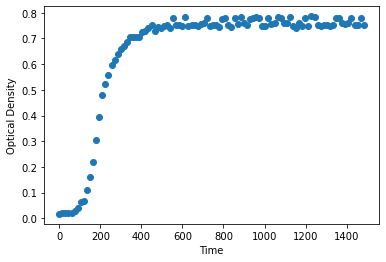

In [3]:
plt.scatter(dat.time,dat.OD);
plt.xlabel('Time')
plt.ylabel('Optical Density')
plt.show()

In [4]:
def gmpz(t,A,wm,k,tm):
  return A+(wm-A)*np.exp(-np.exp(-k*(t-tm)))

In [5]:
from scipy.optimize import curve_fit

 The *curve\_fit* function may become unstable, e.g. generating **NaN** or **Inf**, depending upon the equation and starting parameters. Convergence is better if we guess reasonable starting point for parameters, this is done using p0. We can also set sensible bound on the parameter via <code>bounds = ([lower limits],[upper limits])</code>

We will just estimate *p0* and *bounds* by inspecting the graph above.

In [6]:
A = min(dat.OD)
Wm = max(dat.OD)
k = 0.03
Tm = 200
p0 = [A,Wm,k,Tm]
p0

[0.01717597970829579, 0.7864616264748774, 0.03, 200]

In [7]:
bnd = [0,0.6,0.001,0],[0.1,1.2,1.0,300]
bnd

([0, 0.6, 0.001, 0], [0.1, 1.2, 1.0, 300])

In [8]:
params, covariance = curve_fit(gmpz,dat['time'],dat['OD'],p0=p0,bounds=bnd)
A = params[0]
Wm = params[1]
k = params[2]
Tm = params[3]
print(f'A: {A:0.3f} Wm: {Wm:0.3f} k: {k:0.3f} Tm: {Tm:0.3f}')

A: 0.019 Wm: 0.759 k: 0.017 Tm: 174.405


In [9]:
ypred = gmpz(dat.time,A,Wm,k,Tm)

In [10]:
from sklearn.metrics import r2_score

In [11]:
R2 = r2_score(dat.OD,ypred)
print(f'R2 Score: {R2:0.3f}')

R2 Score: 0.996


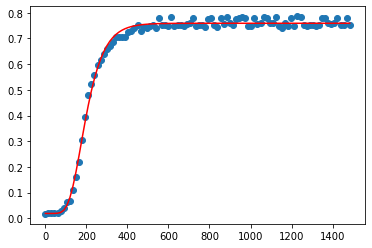

In [12]:
plt.plot(dat.time,ypred,color='red')
plt.scatter(dat.time,dat.OD)
plt.show()

Derived parameters:

In [13]:
mu = (Wm - A)*k/np.exp(1) #max slope
L = (Tm*k-1)/k # lambda
print(f'lambda = {L:0.3f} mu = {mu:0.3f}')

lambda = 113.964 mu = 0.005


In [14]:
Lc = A - L*mu
Ly = mu*Tm + Lc
print(f'Lc = {Lc:0.3f} Ly = {Ly:0.3f}')

Lc = -0.494 Ly = 0.291


In [15]:
abline = [x*mu + Lc for x in dat.time]

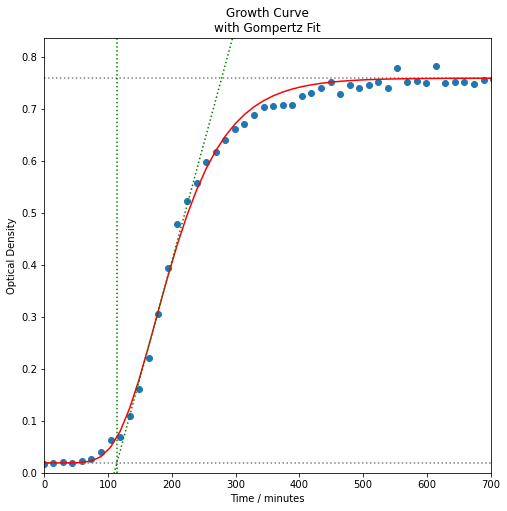

In [16]:
plt.figure(figsize=(8,8))

plt.plot(dat.time,ypred,color='red')
plt.scatter(dat.time,dat.OD)
plt.xlim(0,700)
plt.ylim(0,max(dat.OD)+0.05)
plt.hlines([Wm,A],0,700,color='gray',linestyles='dotted')
plt.vlines(L,0,max(dat.OD)+0.05,color='green',linestyles='dotted')
plt.plot(dat.time,abline,color='green',linestyle='dotted')
plt.xlabel('Time / minutes')
plt.ylabel('Optical Density')
plt.title('Growth Curve\nwith Gompertz Fit')
plt.show()

Notice that here we have defined _lambda_ to be where the tangent to maximum growth rate crosses the base line. Other definitions are possible, for example based on reaching some small fraction of maximum growth. 

## The Bootstrap: Finding Parameter Confidence Intervals
Ideally, if we wanted to find the distribution of some measurement, we would perform many repeat experiments. In other words, we would drawn many samples (each of size, *n*) from the population and calculate the property of interest for each sample. These properties or measurements would then give us the *sampling distribution* from which we could obtain confidence intervals. Notice that the sampling distribution depends on *n* and is not the same as **F**.

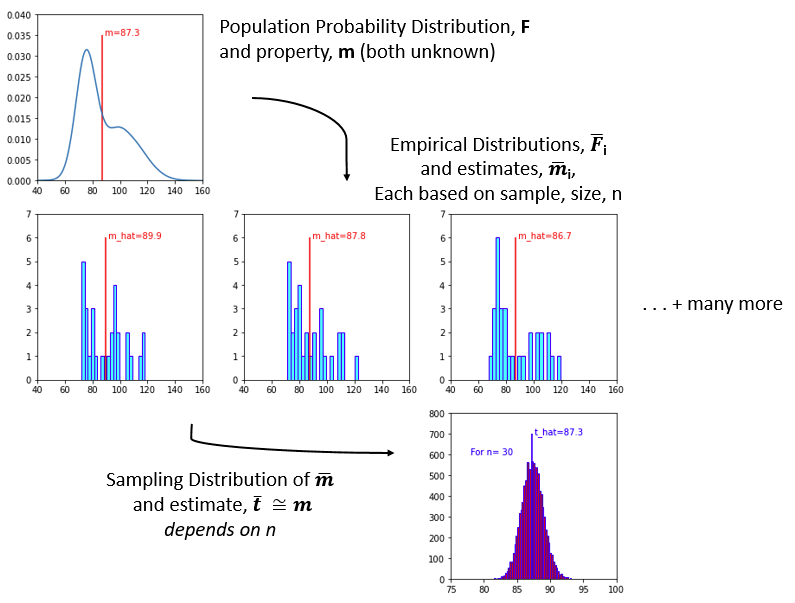

Unfortunately, many experiments are too expensive in terms of time and / or resources, e.g. growth curve experiment may take 24 hours or longer. In fact, we only have a single sample: the results of one experiment.

The trick we adopt is this: use our *one sample* as a proxy for the unknown population probability density, and take *bootstrap* or *re-samples* from this. Bootstrap sampling is taking *n* samples with replacement. When we do this, some data points will be duplicated, some left out altogether; this is expected. Notice that we keep *n* the same as the original sample size. (because the sampling distributions depends on *n*).

Let's see how to code this up to find a confidence interval for the growth curve lag time, *lambda*

First we encapsulate our curve fitting routine into a functions the fits some data and returns *lambda*

In [17]:
def findLambda(time,OD,p0,bnd):  
    params, covariance = curve_fit(gmpz,time,OD,p0=p0)
    #test if the fit failed
    if np.any(np.isinf(covariance)):
        return np.NaN
    A = params[0]
    Wm = params[1]
    k = params[2]
    Tm = params[3]
    mu = (Wm - A)*k/np.exp(1) #max slope
    L = (Tm*k-1)/k # lambda
    return L
    

In [18]:
findLambda(dat.time,dat.OD,p0,bnd)

113.96362148135131

Next loop of Bootstraps

In [19]:
boots = 1000
L = []
n = len(dat.time)
idx = [i for i in range(n)]

In [20]:
for b in range(boots):
    bi = np.random.choice(idx,n)
    t = dat.time[bi]
    od = dat.OD[bi]
    #try to get valid result
    for i in range(10):
        tmp = findLambda(t,od,p0,bnd)
        if ~np.isnan(tmp):
            break
    L.append(tmp)

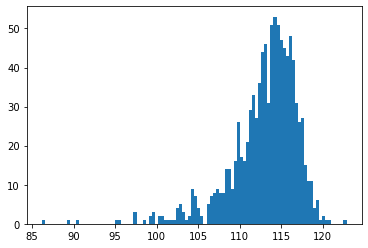

In [21]:
plt.hist(L,bins=100)
plt.show()

In [22]:
ll,med,ul=np.percentile(L,[25,50,97.5])

In [23]:
print(f'Lambda: lower limit {ll:0.2f} median {med:0.2f} upperlimit {ul:0.2f} 95% CI')

Lambda: lower limit 111.31 median 113.83 upperlimit 118.49 95% CI


## Bootstrap Caveats 

When we sample the population, regions where the probability density is low will be sparsely sampled, and subsequent bootstraps will represent these regions poorly. This is exacerbated if the sample size is low. In fact, if the sample size is very low (say < 8), there are too few possible [unique] bootstrap samples, and bootstrap performance is poor.

Thus, the extremes of a distribution are often poorly represented and confidence intervals found can be too narrow: they have *poor coverage*. We usually try to keep *n* high to mitigate this, but distributions that are skewed with low intensity tails may still be a problem.

## How many bootstrap samples?

In principle, the *Full Bootstrap* would include all possible unique bootstrap samples, however, this quickly rises to enormous numbers. In the *Monte Carlo Bootstrap* [random re-sampling], we have described, a minimum of 1000 re-samples should be taken. some authors suggest even higher number, e.g. 10<sup>4</sup>.

## Exercise
1. Reformulate the above code into a function that returns the confidence limits for all of the parameters, **A, Wm, k, Tm & mu**.
2. Apply these techniques to curve fitting a function that is relevant to your research.